<a href="https://colab.research.google.com/github/ChoeTaeBin/deep_learning_study/blob/master/RNN_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM#
(Long Short Term Memory)
  
기본 RNN은 과거의 중요한 정보도 오래되었다는 이유로 잊혀지게되는 문제점이 있다.
그리고 이 문제는 LSTM을 통해서 어느정도 해결 할 수 있다.

#LSTM의 내부요소#  
output gate : 기억 셀의 내용을 어느정도 출력에 반영할지를 조정  
forgate gate : 기억 셀의 내용을 어느정도 남길지를 조정  
input gate : 입력 및 1시각 이전의 출력을 어느정도 기억셀에 반영할지를 조정  
Memory cell(기억셀): 과거의 기억을 보유  
  
각각 게이트들은 일종의 벡터로 이들을 합성곱(성분끼리 곱)하면 원하는 대로 기억을조정할 수 있다.  
이 벡터들은 학습과정에서 손실을 최소화하는 방향으로 갱신된다.

#GRU#
(Gated Recurrent Unit)  
경량화 된 LSTM이라고 볼 수 있다. 파라미터 수를 줄여서 개산속도를 개선했다.  
forget gate + input gate -> update gate  
output gate -> reset gate  
cell state + hidden state -> hidden state

#RNN(LSTM)을 이용한 이미지 생성#

In [1]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

데이터 가져오기

In [2]:
fmnist_data = FashionMNIST(root = "./data", train=True, download = True, transform = transforms.ToTensor())
fmnist_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
print(f"데이터 수 {len(fmnist_data)}")

100%|██████████| 26421880/26421880 [00:02<00:00, 9238101.09it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208511.74it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 792034.18it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20821867.88it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

데이터 수 60000


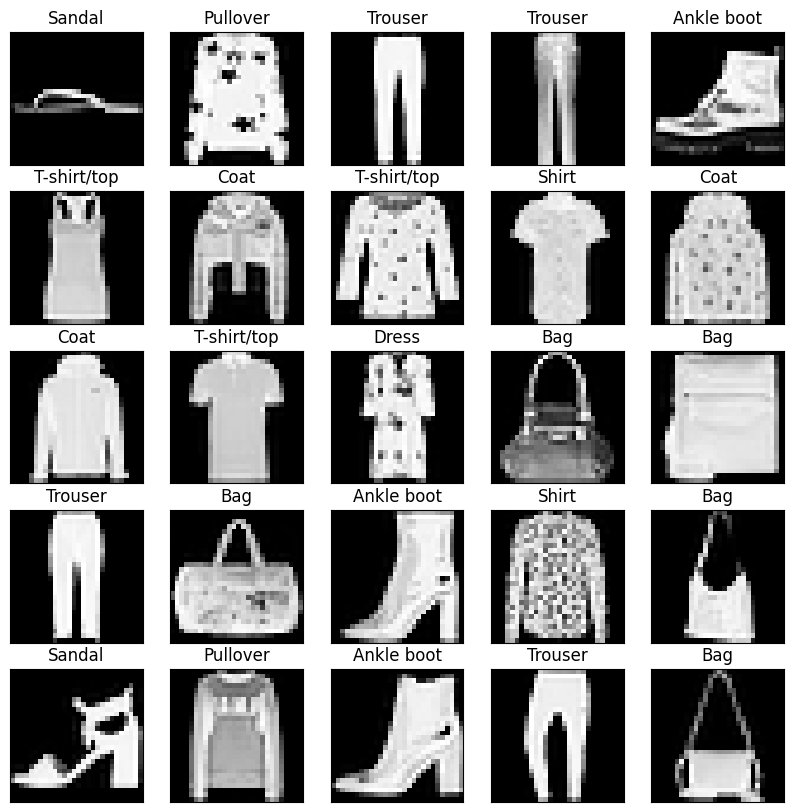

In [3]:
n_image = 25 #보여줄 이미지의 수
fmnist_loader = DataLoader(fmnist_data, batch_size = n_image, shuffle=True)
dataiter = iter(fmnist_loader)
dataiter = iter(fmnist_loader)
images, labels = next(dataiter)


img_size = 28
plt.figure(figsize = (10, 10))
for i in range(n_image):
  ax = plt.subplot(5, 5, i+1)
  ax.imshow(images[i].view(img_size, img_size), cmap = "Greys_r")
  label = fmnist_classes[labels[i]]
  ax.set_title(label)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

데이터 전처리  
이미지 데이터를 시계열데이터로 볼것이다. 행 -> 각 시간, 열 -> 입력 데이터  
28 * 28데이터에서 최초 14행은 시드가되고 이를 이용해서 나머지 아래 14행을 한 줄씩 예측한다

In [4]:
import torch
from torch.utils.data import TensorDataset

n_time = 14
n_in = img_size #입력 데이터 픽셀 수
n_mid = 256 #rnn이 출력할 데이터 픽셀 수
n_out = img_size #최종 예측해야할 픽셀 수
n_sample_in_img = img_size - n_time #이미지 한장이 몇개의 샘플인지

In [5]:
dataloader = DataLoader(fmnist_data, batch_size = len(fmnist_data), shuffle = False) #한번에 모든 이미지를 다꺼냄
dataiter = iter(dataloader)
train_imgs, labels = next(dataiter)
train_imgs = train_imgs.view(-1, img_size, img_size) #(60000, 28, 28)

In [6]:
n_sample = len(train_imgs) * n_sample_in_img #샘플 수

input_data = torch.zeros((n_sample, n_time, n_in)) #입력
correct_data = torch.zeros((n_sample, n_out)) #정답

for i in range(len(train_imgs)): #모든 이미지 동안
  for j in range(n_sample_in_img): #한 이미지 당 뽑아 낼 수 있는 샘플 수 동안
    sample_id = i*n_sample_in_img + j
    input_data[sample_id] = train_imgs[i, j : j+n_time] #14크기의 time slice만큼을 떼어내서 input으로 사용
    correct_data[sample_id] = train_imgs[i, j+n_time] #바로 그 다음행의 28개의 픽셀들이 target임

In [12]:
dataset = TensorDataset(input_data, correct_data)
train_loader = DataLoader(dataset, batch_size = 128, shuffle = True)

테스트용 데이터 만들기

In [7]:
n_disp = 10

disp_data = FashionMNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())
disp_loader = DataLoader(disp_data, batch_size = n_disp, shuffle = False)
dataiter = iter(disp_loader) #이터레이터
disp_imgs, labels = next(dataiter) #데이터를 (10개)꺼낸다
disp_imgs = disp_imgs.view(-1, img_size, img_size)

모델 구축

In [14]:
import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = nn.LSTM(
        input_size = n_in, #입력 픽셀 크기
        hidden_size = n_mid, #LSTM입장에서는 출력크기
        batch_first = True, #입력 폼을 (배치크기, 시각 수, 입력수)크기로 받을 것이다.
    )
    self.fc = nn.Linear(n_mid, n_out)

  def forward(self, x):
    #y_rnn: 모든 시각의의 출력, h: 최후 출력, c: 기억셀
    y_rnn, (h, c) = self.rnn(x, None)
    y = self.fc(y_rnn[:,-1,:]) #최후시각의 출력만 넣으면 됨 Q 이때 h와 y_rnn[:, -1, :]의 차이는?
    return y

In [26]:
net = Net()
net.cuda()
print(net)

Net(
  (rnn): LSTM(28, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=28, bias=True)
)


이미지 생성용 함수

In [25]:
def generate_images():
  print("Original:")
  plt.figure(figsize = (20, 2))
  for i in range(n_disp):
    ax = plt.subplot(1, n_disp, i+1)
    ax.imshow(disp_imgs[i], cmap = "Greys_r", vmin = 0.0, vmax = 1.0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

  print("Generated:")
  net.eval()
  gen_imgs = disp_imgs.clone()
  plt.figure(figsize = (20, 2))
  for i in range(n_disp):
    for j in range(n_sample_in_img):
      x = gen_imgs[i, j:j+n_time].view(1, n_time, img_size) #아래에서 부터 14칸을 자름
      x = x.cuda()
      gen_imgs[i, j+n_time] = net(x)[0] #예측한 행으로 원본 이미지에 덮어씀

    ax = plt.subplot(1, n_disp, i+1)
    ax.imshow(gen_imgs[i].detach(), cmap = "Greys_r", vmin = 0.0, vmax = 1.0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

optimizer, loss 생성

In [27]:
from torch import optim

loss_fnc = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

학습

Epoch:0, Loss_Train:0.017397471195427124
Original:


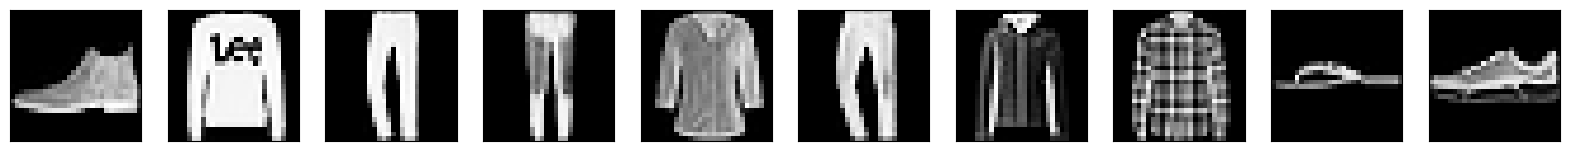

Generated:


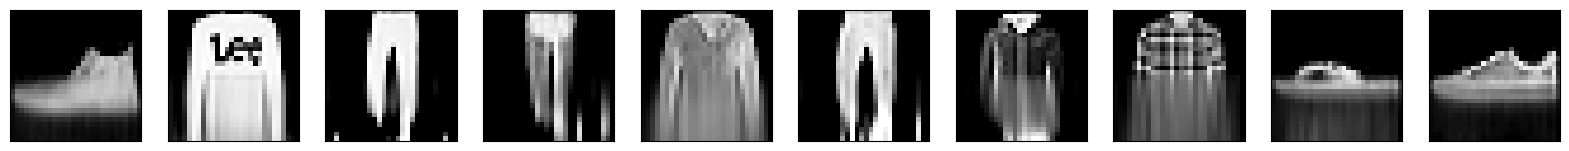

Epoch:5, Loss_Train:0.011115790857406568
Original:


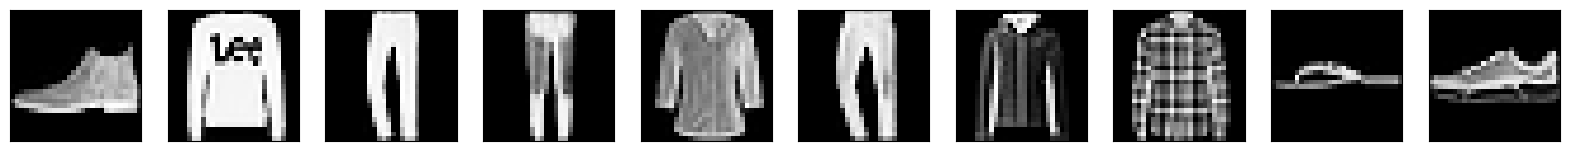

Generated:


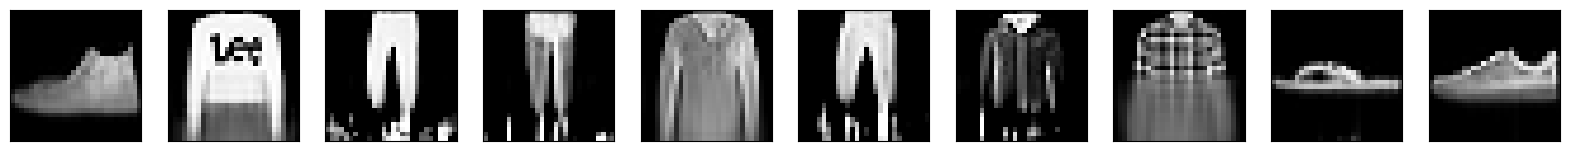

Epoch:10, Loss_Train:0.010178328438036333
Original:


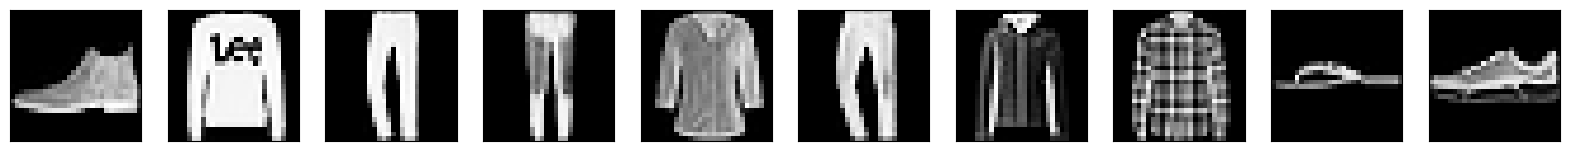

Generated:


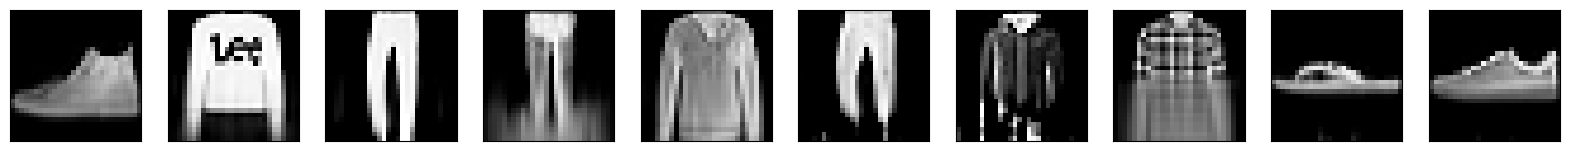

Epoch:15, Loss_Train:0.009610063075547027
Original:


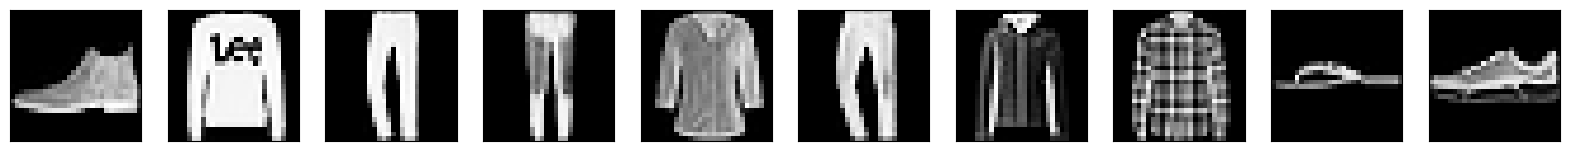

Generated:


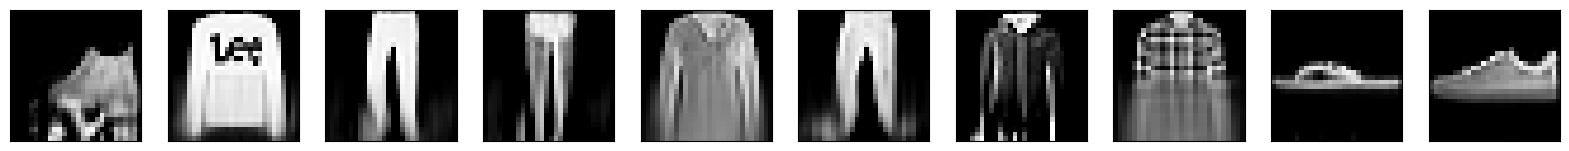

Epoch:20, Loss_Train:0.009197540020417753
Original:


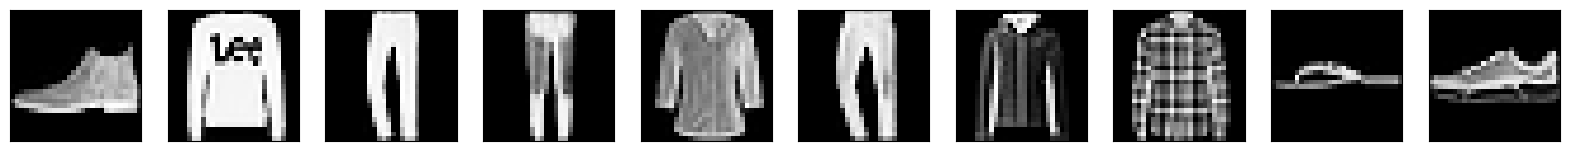

Generated:


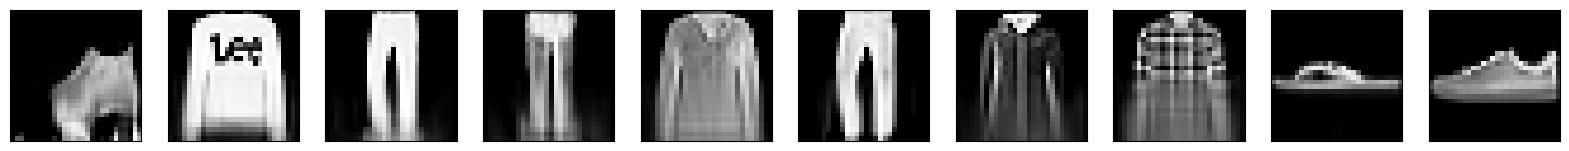

Epoch:25, Loss_Train:0.008880581360017424
Original:


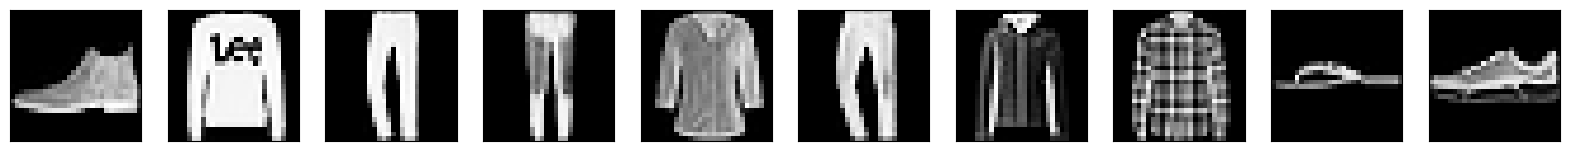

Generated:


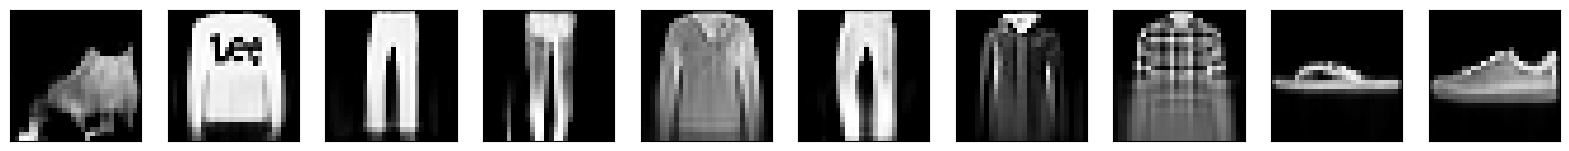

Epoch:29, Loss_Train:0.008693698862757412
Original:


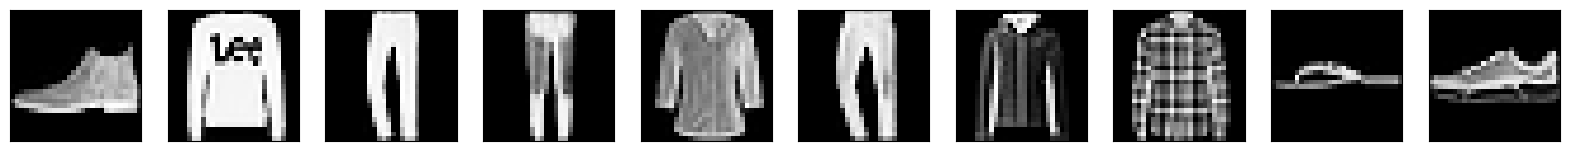

Generated:


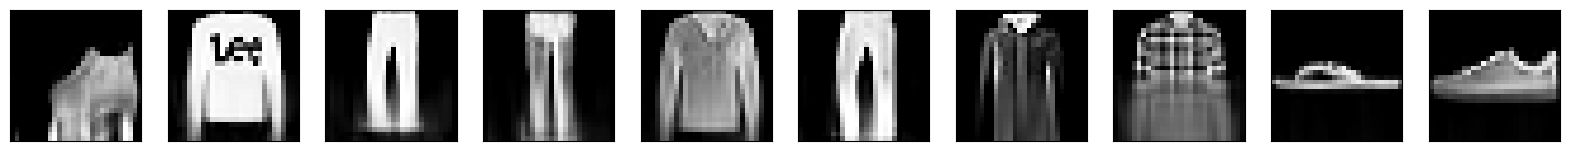

In [28]:
record_loss_train = []

epochs = 30 #에포크 수

for i in range(epochs):
  net.train() #훈련 모드
  loss_train = 0

  for j, (x,t) in enumerate(train_loader):
    x,t = x.cuda(), t.cuda()
    y = net(x)
    loss = loss_fnc(y, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_train += loss.item()

  loss_train /= j+1
  record_loss_train.append(loss_train)

  if(i%5 == 0 or i == epochs-1):
    print(f"Epoch:{i}, Loss_Train:{loss_train}")
    generate_images()

오차 추이

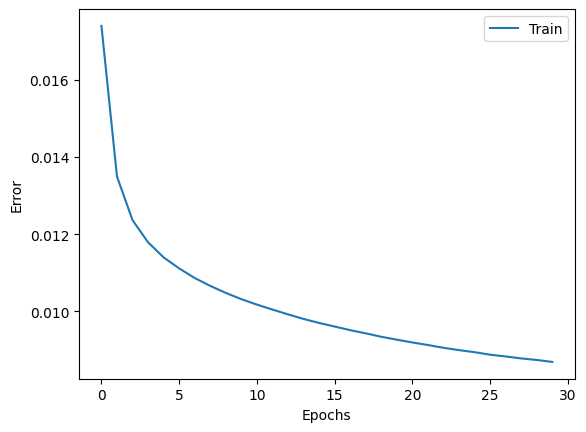

In [29]:
plt.plot(range(len(record_loss_train)), record_loss_train, label = "Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()